# Fitting wells

This notebook introduces the concept of fitting wells and how they are used in `gwrefpy`. The methodology originates from the description by its author [Strandanger (2024)](https://svenskageotekniskaforeningen.se/wp-content/uploads/Publikationer/SGF_Rapporter/2024_2_Akvifars_refmetod.pdf).

This notebook can be downloaded from the source code [here](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/user_guide/2_fitting_wells.ipynb).

To analyse deviations in groundwater level timeseries, the `gwrefpy` methodology relies on observation wells and reference wells. To check for deviations in an observation well, we fit its data to a reference well using regression. When fitting the two wells, we specify a calibration period. If data outside of the calibration period does not follow the fitted regression, a deviation has occurred. 

In this notebook, we will dive deeper into the fitting workflow and showcase this library's associated capabilities.

```{note}
See [this notebook on wells](https://github.com/andersretznerSGU/gwrefpy/blob/main/docs/user_guide/1_intro_gwrefpy.ipynb)
```


In [1]:
import gwrefpy as gr
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
gr.set_log_level("ERROR")
plt.set_loglevel("ERROR")


Log level set to ERROR


## Data

In this notebook, we will work with data provided by `gwrefpy`. Let's load the model using its file name and plot the observation well and reference well separately.

In [2]:
model = gr.Model("deviation_example.gwref")
model

Model(name='deviation example', wells=2, fits=0)

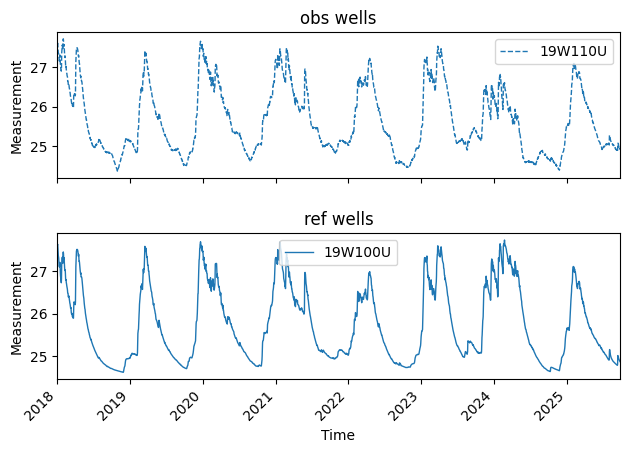

In [3]:
fig, (up, down) = plt.subplots(nrows=2, sharex=True)
model.plot_wells(model.obs_wells, ax=up)
model.plot_wells(model.ref_wells, ax=down)

up.set_title("obs wells")
down.set_title("ref wells")

up.legend()
down.legend()

fig.autofmt_xdate(rotation=45)

## Anatomy of a fit

Let's walk through the anatomy of a fit by fitting the observation well _12GIPGW_ to the reference well _45LOGW_. To fit wells within a model, we call `model.fit()` which has the following signature:

In [4]:
help(model.fit)

Help on method fit in module gwrefpy.fitbase:

fit(obs_well: gwrefpy.well.Well | list[gwrefpy.well.Well] | str | list[str], ref_well: gwrefpy.well.Well | list[gwrefpy.well.Well] | str | list[str], offset: pandas._libs.tslibs.offsets.DateOffset | pandas._libs.tslibs.timedeltas.Timedelta | str, aggregation: Literal['mean', 'median', 'min', 'max'] = 'mean', p: float = 0.95, method: Literal['linearregression', 'npolyfit', 'chebyshev'] = 'linearregression', tmin: pandas._libs.tslibs.timestamps.Timestamp | str | None = None, tmax: pandas._libs.tslibs.timestamps.Timestamp | str | None = None, report: bool = True, **kwargs) -> gwrefpy.fitresults.FitResultData | list[gwrefpy.fitresults.FitResultData] method of gwrefpy.model.Model instance
    Fit reference well(s) to observation well(s) using regression.
    
    Parameters
    ----------
    obs_well : Well | list[Well] | str | list[str]
        The observation well(s) to use for fitting. Can be Well objects,
        well names (strings), or l

The first two arguments determine which wells to use. 

The `offset` and `aggregation` arguments handle cases where the timeseries of the wells are not aligned, see [this notebook](). The wells in this model are sampled daily and cover the same period, which means we can use `"0D"` as the offset which also renders the `aggregation` argument obsolete.

The `p` argument controls which confidence level to use when evaluating the lower and upper bound from which to recognize deviations. We will use the default `p`-value of 0.05.

The `tmin` and `tmax` arguments control the period in which we want to perform the fit. This is an important decision that can only be inferred from prior knowledge of the wells. We want to select this period such that no (or negligble) external factors are affecting head in the observation well. In this example, we will assume that data until 2022 is unaffected and can be used for fitting a regression.

```{important}
The reference well needs to be unaffected by external factors during its entire time period.
```

Currently, `gwrefpy` supports the linear regression fit as demonstrated in [Strandanger (2024)](https://svenskageotekniskaforeningen.se/wp-content/uploads/Publikationer/SGF_Rapporter/2024_2_Akvifars_refmetod.pdf), which is what we will cover in this notebook. Linear regression is currently the only available method, which is why we don't have to explicitly pass it.

Let's do this!

In [5]:
model.fit(
    obs_well="19W110U",
    ref_well="19W100U",
    offset="0D",
    tmax="2022"
)

Statistic,Value,Description
RMSE,0.1514,Root Mean Square Error
R²,0.9699,Coefficient of Determination
R-value,0.9848,Correlation Coefficient
Slope,1.0058,Linear Regression Slope
Intercept,-0.1676,Linear Regression Intercept
P-value,0.0000,Statistical Significance
N,1826,Number of Data Points
Std Error,0.1515,Standard Error
Confidence,95.0%,Confidence Level


By default when calling `fit()`, a summary of the fitted regression is displayed as seen above.

Calling `fit()` results in a `FitResultData` object being created and stored in the model instance's `fits` attribute. Let's plot the resulting fit to verify everything is OK. We use the `plot_fitmethod()` method and pass all available fits knowing it will only contain the fit we just created.

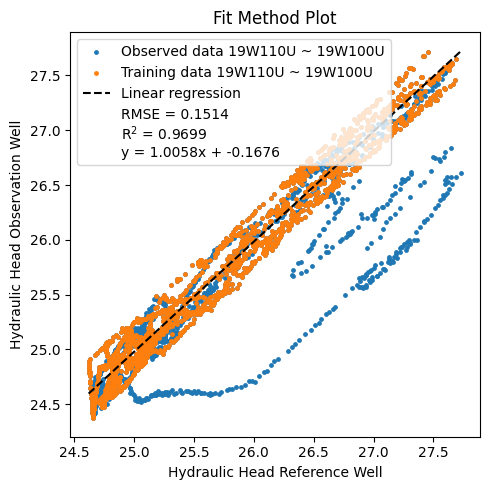

In [6]:
_ = model.plot_fitmethod(model.fits)

We can see that for the training data, which is data used to fit the regression, our fit seems OK. Observed heads outside of this period show a different behavior - one might suspect a deviation!

## Analysing deviations

Evaluating deviation is a key `gwrefpy` feature! Below, we plot the resulting fit and transformed head, along with the lower and upper confidence limit based on our `p` value (0.05) and the fit. 

Below, we retrieve the fit from the model and get the associated fitted timeseries for the reference well and the upper and lower bound associated with the `p` value.

```{tip}
Below, we generate the plot by hand to showcase how to retrieve the fitted timeseries and its associated upper and lower bound. If you want to quickly review a fit and deviations, use `model.plot_fits()`.
```

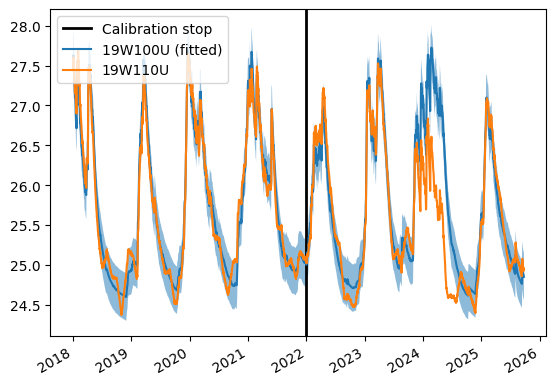

In [7]:
fit = model.get_fits("19W100U")  # we know we only have one fit, so this will be a single object
fitted_ref = fit.get_fit_timeseries()
upper_bound = fit.get_upper_confidence_bound()
lower_bound = fit.get_lower_confidence_bound()

fig, ax = plt.subplots()

_ = ax.fill_between(fitted_ref.index, y1=lower_bound, y2=upper_bound, alpha=0.5)
_ = ax.axvline(pd.Timestamp("2022"), color="black", linewidth=2, label="Calibration stop")


_ = fitted_ref.plot(ax=ax, label="19W100U (fitted)")
_ = obs = model.get_wells("19W110U")
_ = obs.timeseries.plot(ax=ax, label="19W110U")
_ = ax.legend(loc="upper left")

Seems like the observation well (19W110U) dips below the lower bound during 2023 and 2024. Let's zoom into this period and plot the timesteps where this occurs with a different color after retrivieing them with the `get_outliers()` method.

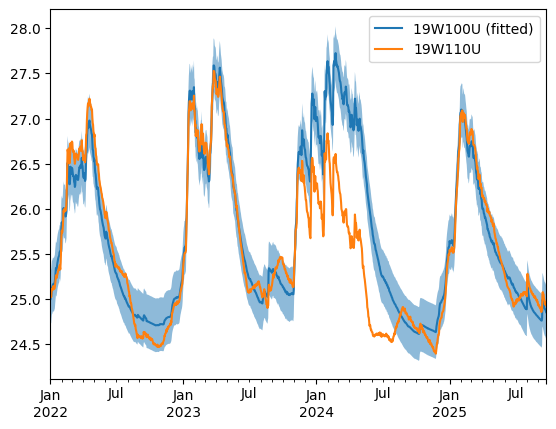

In [8]:
fig, ax = plt.subplots()

ax.fill_between(fitted_ref.index, y1=lower_bound, y2=upper_bound, alpha=0.5)

fitted_ref.loc["2022":].plot(ax=ax, label="19W100U (fitted)")
obs.timeseries.loc["2022":].plot(ax=ax, label="19W110U")
_ = ax.legend()

## Generate multiple fits at once

With `gwrefpy`, you can fit as many reference wells as you like to a single observation well. This is useful if you have many wells to choose from, and would like to rank their fit performance.

Below, we load an example model with many observation and reference wells and clear its existing fits.

In [9]:
large_model = gr.Model("large_example.gwref")
large_model.fits = []
large_model.obs_wells[:3]

[Well(name=01OBS), Well(name=02OBS), Well(name=03OBS)]

We choose a observation well and then run `best_fit()`, which will default to perform a fit for all available reference wells.

This project many reference wells, so we select only the top 3 fits with `remove_fits_by_n()` and then plot the resulting regression fit by fit.

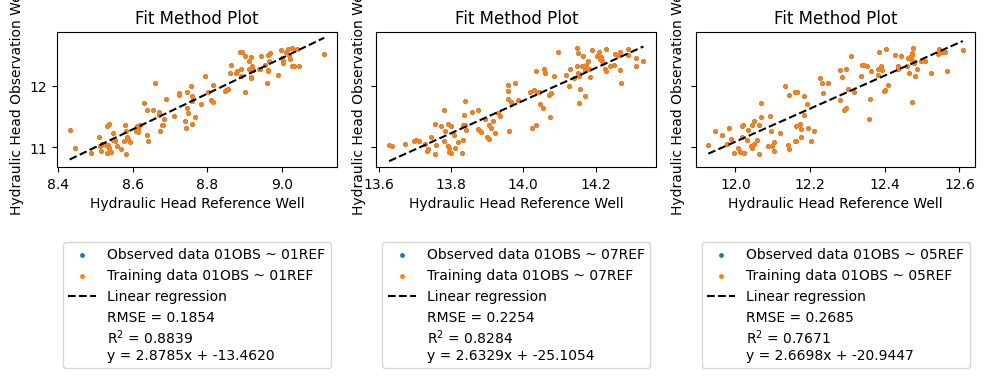

In [10]:
_ = large_model.best_fit(obs_well="01OBS", offset="0D")
_ = large_model.remove_fits_by_n("01OBS", 3)

fig, axs = plt.subplots(ncols=len(large_model.fits), sharey=True, figsize=(10,4))
for ax, fit in zip(axs, large_model.fits):
    _ = large_model.plot_fitmethod(fit, ax=ax)
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((0.5, -0.5))
    legend.set_loc("upper center")

This is a great way to evaluate many reference wells for a single observation well!

# Other fitting methods
In addition to linear regression, `gwrefpy` also supports n-polynomial fitting and Chebyshev polynomial fitting. These methods are useful when the fitting relationship between the observation well and reference well requires a higher degree of freedom. Below, we fit the same wells as before, but this time using an n-polynomial of degree 10.

```{note}
These methods are described in more detail in the [Fitting methods](user_guide/index.md#fitting-methods) section of the user guide.
```

In [11]:
model.fit(
    obs_well="19W110U",
    ref_well="19W100U",
    offset="0D",
    tmax="2022",
    method="npolyfit",
    degree=10,
)

Statistic,Value,Description
RMSE,0.1499,Root Mean Square Error
Degree,10,Degree of Polynomial Fit
Coefficient 0,-0.0000,Polynomial Coefficient
Coefficient 1,0.0000,Polynomial Coefficient
Coefficient 2,-0.0010,Polynomial Coefficient
Coefficient 3,0.0018,Polynomial Coefficient
Coefficient 4,0.5827,Polynomial Coefficient
Coefficient 5,-0.2733,Polynomial Coefficient
Coefficient 6,-394.1800,Polynomial Coefficient
Coefficient 7,-474.7302,Polynomial Coefficient


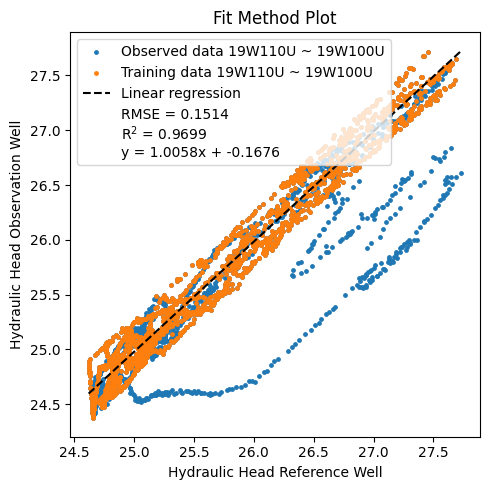

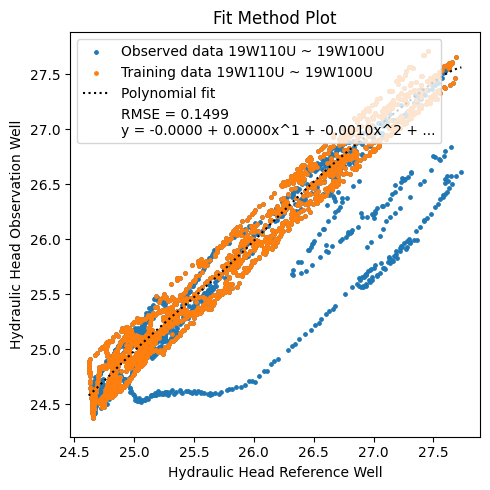

In [12]:
_ = model.plot_fitmethod(model.fits, plot_separately=True)

We can see that the n-polynomial fit captures the training data differently than the linear regression. Let's evaluate the difference in fitted values between the two methods.

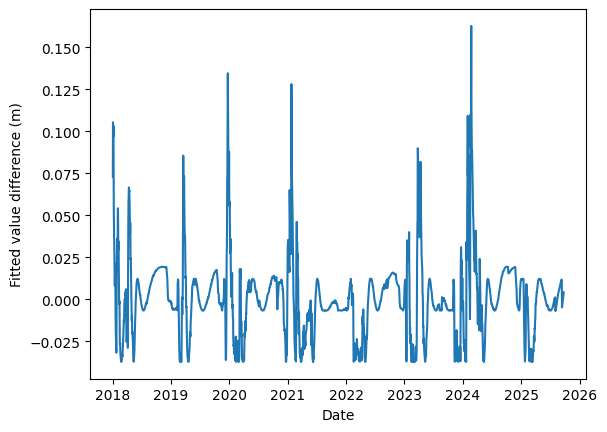

In [13]:
fit = model.get_fits("19W100U", method="npolyfit")  # we know that we have two fits now, so this will give us both
fitted_ref2 = fit.get_fit_timeseries()

fig, ax = plt.subplots()

_ = ax.plot(fitted_ref.index, fitted_ref-fitted_ref2, label="Difference in fit", color="C0")
_ = ax.set_xlabel("Date")
_ = ax.set_ylabel("Fitted value difference (m)")


We can see that the two fitting are very similar for this specific case. Depending on the application, one might be preferred over the other.

Happy fitting!